# Create food product ingredient matrix

This notebook transforms the ingredients for product data into a matrix for clustering

At the time of writing this code, the data is pulled from FoodData Central for Oct 2022, which is an upgrade to the 2018 Branded Foods product database: https://fdc.nal.usda.gov/download-datasets.html

This specific matrix construction is on the food_nutrient table.

__Note:__ At the time of this writing, all ingredients were stored as an unformatted list which would be seen on a food label.



Field descriptions (https://fdc.nal.usda.gov/portal-data/external/dataDictionary)
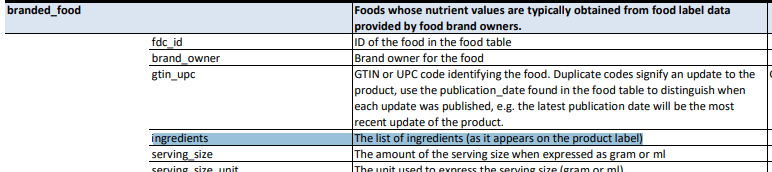


## Connect to the postgresql server and pull data

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import sqlalchemy as sal

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sqlalchemy import text

In [3]:
nutrient_matrix_csv_p = r"../../data/ingredients_matrix.csv.gz"

#### Connect to the nourish database

In [4]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [5]:
nourish_user = "gmichael"

nourish_pswd = "567khcwx3s"

engine = sal.create_engine('postgresql+psycopg2://' + nourish_user + ':' + nourish_pswd + '@awesome-hw.sdsc.edu/nourish')
conn = engine.connect()

#### Pull the fdc_idcs and their ingredients

In [6]:
query_ingredients = text('''SELECT "fdc_id", "ingredients"
from "usda_2022_branded_food_product"''')

result = conn.execute(query_ingredients)

ingredient_data = [i for i in result]

print(ingredient_data[0:2])

conn.close()

[(356068, 'MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FLOUR, NIACIN, REDUCED IRON, THIAMINE MONONITRATE [VITAMIN B1], RIBOFLAVIN [VITAMIN B2], FOLIC ACID), SUG ... (122 characters truncated) ... (INVERT SYRUP, MOLASSES), BUTTER, CORNSTARCH, NONFAT MILK, CONTAINS 2 PERCENT OR LESS OF: EGG WHITES, SALT, LEAVENING (BAKING SODA) AND SOY LECITHIN.'), (356069, 'INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED TOMATO CONCENTRATE), ROASTED POBLANO CHILI PEPPERS, WATER, ROASTED CORN, DICED TOMATOES IN TOMATO JUICE, GARLIC, DISTILLED VINEGAR, ONIONS, ROASTED RED PEPPERS, SALT, CILANTRO, CUMIN.')]


## Create a food ingredient matrix

In [7]:
ingredient_df = pd.DataFrame(ingredient_data)
print(ingredient_df.shape) #there are more fdc_ids in this table than the nutrients bc not every fdc_id has nutrients
ingredient_df['ingredients'] = ingredient_df['ingredients'].str.upper()
ingredient_df.head()

(1702125, 2)


,fdc_id,ingredients
0,356068,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...
1,356069,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ..."
2,356070,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...
3,356071,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ..."
4,356072,"INGREDIENTS: CREAM, WATER, PARMESAN CHEESE (MI..."


#### Tokenize the ingredients column in the dataframe

In [8]:
%%time
ingredient_df['ingredients_tokenized'] = ingredient_df['ingredients'].apply(lambda x: word_tokenize(x))
ingredient_df.head()

CPU times: user 5min 56s, sys: 11 s, total: 6min 7s
Wall time: 6min 8s


,fdc_id,ingredients,ingredients_tokenized
0,356068,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...,"[MADE, FROM, :, UNBLEACHED, ENRICHED, WHEAT, F..."
1,356069,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ...","[INGREDIENTS, :, CRUSHED, TOMATOES, (, WATER, ..."
2,356070,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...,"[MADE, FROM, :, UNBLEACHED, ENRICHED, WHEAT, F..."
3,356071,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ...","[INGREDIENTS, :, CRUSHED, TOMATOES, (, WATER, ..."
4,356072,"INGREDIENTS: CREAM, WATER, PARMESAN CHEESE (MI...","[INGREDIENTS, :, CREAM, ,, WATER, ,, PARMESAN,..."


#### Write a function to loop through the tokens and pull out the ingredients

In [9]:
def extract_ingredients(tokenized_list):
    '''
    Function is designed to loop through a tokenized list of FDA ingredients and attempt to pull out only the ingredients. 
    By nature FDA ingredients are not formatted well and contain nested lists. For example, an ingredient may look like:
    "Made from: Oils (Vegetable Oil, Olive Oil), Salt, DILL JALAPENOS (WATER, VINEGAR, SALT, SPICES)"
    In this case, we want to extract all the nested ingredients
    '''
    ingredient_list = [] #list of ingredients that will be returned

    ignore_characters_list = [",", "(", ")", ":", ";", "[", "]", ".", "*", "{", "}", "IN", "AND", "AND/OR"] #special characters to consider
    
    len_tokenized_list = len(tokenized_list)

    for i in range(len_tokenized_list):
        curr_tok = tokenized_list[i]
        if i == 0: #if its the first token, add it to the list
            ingredient_list.append(curr_tok)
        else:
            #if the current token is not a special character, its an ingredinent
            if curr_tok not in ignore_characters_list:
                #first we want to check the previous token. If its not a special character, then 
                #the two tokens need to be combined into one phrase such as 'WHEAT FLOUR'
                prev_tok = tokenized_list[i - 1]
                if prev_tok not in ignore_characters_list:
                    #remove the last ingredient and combine it with the current
                    prev_ingredient = ingredient_list.pop()
                    curr_tok = prev_ingredient + " " + curr_tok
                    ingredient_list.append(curr_tok)
                else:
                    #last token was a special character, so we will just append the current ingredient
                    ingredient_list.append(curr_tok)
            else:
                #if the current token starts with a colon (a list identifier), then we need to remove the first phrase outside of that list
                #since we only want to keep the baseline ingredients
                #for example with MADE FROM: ENRICHED WHEAT FLOUR, we only want ENRICHED WHEAT FLOUR
                if curr_tok in (":"):
                    prev_tok = tokenized_list[i - 1]
                    if prev_tok not in ignore_characters_list:
                        ingredient_list.pop()
    return set(ingredient_list)

#### Apply the function on the tokens in the df

In [10]:
%%time
ingredient_df['ingredients_tokenized'] = ingredient_df['ingredients_tokenized'].apply(lambda x: extract_ingredients(x))
ingredient_df.head()

CPU times: user 34.6 s, sys: 2.3 s, total: 36.9 s
Wall time: 37 s


,fdc_id,ingredients,ingredients_tokenized
0,356068,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...,"{HYDROGENATED SOYBEAN, INVERT SYRUP, BAKING SO..."
1,356069,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ...","{CILANTRO, ROASTED POBLANO CHILI PEPPERS, ONIO..."
2,356070,MADE FROM: UNBLEACHED ENRICHED WHEAT FLOUR (FL...,"{CHOCOLATE PROCESSED WITH ALKALI, BAKING SODA,..."
3,356071,"INGREDIENTS: CRUSHED TOMATOES (WATER, CRUSHED ...","{ONIONS, TOMATO JUICE, WATER, DEHYDRATED ONION..."
4,356072,"INGREDIENTS: CREAM, WATER, PARMESAN CHEESE (MI...","{WATER, ENZYMES, CULTURES, ENZYME MODIFIED EGG..."


Lets see how a random selection does

In [11]:
import random
for samp in random.sample(range(0, 10000), 5):
    ingredients = ingredient_df.iloc[samp]['ingredients']
    ingredients_tokenized = ingredient_df.iloc[samp]['ingredients_tokenized']
    print('\noriginal:')
    print(ingredients)
    print('\ncleaned list:')
    print(ingredients_tokenized) 


original:
SAUSAGE: MECHANICALLY SEPARATED CHICKEN, WATER, SALT, MODIFIED CORN STARCH, CONTAINS 2% OR LESS OF: BEEF, PORK, CORN SYRUP, DEXTROSE, NATURAL FLAVORS, SODIUM NITRATE, GARLIC POWDER, BROTH: CHICKEN BROTH.

cleaned list:
{'CHICKEN BROTH', 'SODIUM NITRATE', 'DEXTROSE', 'GARLIC POWDER', 'PORK', 'WATER', 'BEEF', 'SALT', 'CORN SYRUP', 'MODIFIED CORN STARCH', 'MECHANICALLY SEPARATED CHICKEN', 'NATURAL FLAVORS'}

original:
PORK, WATER, SALT, SALT, DEXTROSE, SPICES (INCLUDING PEPPER AND FENNEL), PAPRIKA, SPICE EXTRACTIVES, EXTRACTIVES OF PAPRIKA, BHA, BHT, AND CITRIC ACID TO HELP PROTECT FLAVOR.

cleaned list:
{'BHA', 'DEXTROSE', 'BHT', 'PORK', 'WATER', 'SPICES', 'CITRIC ACID TO HELP PROTECT FLAVOR', 'PAPRIKA', 'SPICE EXTRACTIVES', 'SALT', 'INCLUDING PEPPER', 'FENNEL', 'EXTRACTIVES OF PAPRIKA'}

original:
CANE SUGAR, SWEET BROWN RICE FLOUR, BROWN SUGAR, TAPIOCA STARCH, ARROWROOT POWDER, RICE SYRUP SOLIDS (RICE SYRUP SOLIDS, RICE PROTEIN, TOCOPHEROLS), CITRUS FIBER, BAKING SODA, SALT,

#### Dedupe the ingredients

In [13]:
ingredient_list = ingredient_df['ingredients_tokenized'].to_list()

In [14]:
from itertools import chain
ingredient_list = list(chain.from_iterable(ingredient_list))

In [15]:
ingredient_list = set(ingredient_list)

In [16]:
len(ingredient_list)

149192

In [23]:
df_ingredients = pd.DataFrame (ingredient_list, columns = ['ingredients'])

In [22]:
!pip install pandas-dedupe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 1.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 991.7 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 7.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 232.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 218.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 495.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 951.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 1.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.4/231.4 kB 1.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 3.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... d

In [25]:
import pandas_dedupe

In [ ]:
df_ingredients = pandas_dedupe.dedupe_dataframe(df_ingredients, ["ingredients"])

Importing data ...


In [28]:
vectorizer = CountVectorizer(lowercase = False, stop_words = 'english', analyzer=lambda x: x)

In [ ]:
ingredient_count_df = vectorizer.fit_transform(ingredient_df['ingredients'])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [ ]:
ingredient_count_df

In [34]:
vocab = vectorizer.vocabulary_

In [41]:
vocab = list(vocab.keys())

In [42]:
sorted(vocab)

['',
 'A',
 'A  PRESERVATIVE',
 'A A PRESERVATIVE',
 'A ACETATE',
 'A AND DS',
 'A AND E',
 'A ARTIFICIAL FLAVOR',
 'A B',
 'A B B VITAMIN',
 'A B VITAMIN',
 'A B VITAMIN NIACINAMIDE',
 'A BEER TYPE FLAVOR',
 'A BETA',
 'A BEVERAGE BREWED FROM WATER',
 'A BIEND OF BLACK',
 'A BLEND OF',
 'A BLEND OF CALCIUM AND VITAMIN C',
 'A BLEND OF CALCIUM AND VITAMIN C TO MAINTAIN FRESHNESS',
 'A BLEND OF CALCIUM AND VITAMIN C TO MAINTAIN FRESHNESS AND COLOR',
 'A BLEND OF CALCIUM AND VITAMIN TO MAINTAIN COLOR',
 'A BLEND OF CALCIUM AND VITAMINS TO MAINTAIN COLOR',
 'A BLEND OF CANOLA',
 'A BLEND OF CHEDDAR AND MONTEREY JACK CHEESE',
 'A BLEND OF CHEESES',
 'A BLEND OF CHILI PEPPER',
 'A BLEND OF COARSE AND FINE',
 'A BLEND OF COCOA POWDERS',
 'A BLEND OF DRIED RED CHILE FLAKES',
 'A BLEND OF EXOTIC POTATOES',
 'A BLEND OF EXTRA VIRGIN OLIVE OIL AND SUNFLOWER OIL',
 'A BLEND OF FAIR TRADE COFFEE BEANS FROM AFRICA',
 'A BLEND OF FISH WITH NATURAL AND ARTIFICIAL FLAVORS',
 'A BLEND OF FLORIDA',
 'A 

In [56]:
print([x.strip() for x in ingredient_df.iloc[10]['ingredients'].split(',')])

['Whole Wheat Flour', 'Enriched Wheat Flour', 'Wheat Flour', 'Malted Barley Flour', 'Ascorbic Acid', 'Niacin', 'Reduced Iron', 'Thiamine Mononitrate', 'Riboflavin', 'Folic Acid', 'Water', 'Brown Sugar', 'Granulated Sugar', 'Contains', 'Or Less of The Following Ingredients', 'Yeast', 'Salt', 'Wheat Gluten', 'Honey', 'Soybean Oil', 'Molasses', 'Mono and Diglycerides', 'Corn Meal', 'Calcium Propionate', 'L', 'Cysteine', 'Enzymes', '']


In [46]:
ingredient_df.head(50)

,fdc_id,ingredients
0,2317926,"Whole Grain Wheat Flour, Enriched Wheat Flour,..."
1,2317927,"Ingredients, boned whole hog, water, salt, spi..."
2,2317928,"PEAS, WATER, SUGAR, SALT"
3,2317929,"INGREDIENTS, WATER, CARROTS, POTATOES, SEASONE..."
4,2317930,"Enriched Wheat Flour ,Wheat Flour, Malted Barl..."
5,2317931,PORK RIBS
6,2317932,"Apples, Water, Mango Puree, Peach Puree, Natur..."
7,2317933,"Enriched White Rice ,rice, iron, niacin, thiam..."
8,2317934,"Corn Syrup, Sugar, Modified Corn Starch, Apple..."
9,2317935,"Cranberries, Sugar and Sunflower Oil"


### Ingredient list curated by chatgpt

Salt, Water, Sugar, Olive Oil, Garlic, Onion, Butter, Black Pepper, All-Purpose Flour, Eggs, Lemon Juice, Milk, Parmesan Cheese, Tomatoes, Baking Powder, Ground Cinnamon, Vanilla Extract, Baking Soda, Vegetable Oil, Honey, Cumin, Brown Sugar, Paprika, Soy Sauce, Chicken, Red Pepper Flakes, Cinnamon, White Wine Vinegar, Mustard, Lemon Zest, Thyme, Bay Leaves, Cornstarch, Almonds, Anchovy, Apples, Apricot, Artichoke, Asparagus, Avocado, Bacon, Barbecue Sauce, Basil, Beans, Beef, Beetroot, Bell Pepper, Black Olives, Blackberries, Blue Cheese, Blueberries, Breadcrumbs, Broccoli, Brussel Sprouts, Cabbage, Cake Flour, Camembert Cheese, Canned Tomatoes, Caper, Capers, Caraway Seeds, Cardamom, Carrots, Cashews, Cauliflower, Cayenne Pepper, Celery, Cheddar Cheese, Cheese, Cherries, Chickpeas, Chili Flakes, Chili Powder, Chives, Chocolate, Chocolate Chips, Chorizo, Cilantro, Cloves, Cocoa Powder, Coconut, Coconut Milk, Coconut Oil, Cod, Coffee, Collard Greens, Coriander, Corn, Corn Syrup, Cornflour, Cottage Cheese, Couscous, Crab, Cranberries, Cream, Cream Cheese, Creme Fraiche, Cucumber, Curry Leaves, Curry Powder, Dark Chocolate, Dates, Dijon Mustard, Dill, Dragonfruit, Edam Cheese, Edamame, Egg Noodles, Egg Yolks, Endive, English Muffins, Fava Beans, Fennel, Feta Cheese, Fig, Fish, Flaxseed, French Bread, Fresh Basil, Fresh Cilantro, Fresh Ginger, Fresh Mint, Fresh Parsley, Fresh Rosemary, Fresh Thyme, Gelatin, Ghee, Ginger, Goat Cheese, Golden Syrup, Gouda Cheese, Graham Cracker Crumbs, Granola, Granulated Sugar, Grapefruit, Grapes, Greek Yogurt, Green Beans, Green Bell Pepper, Green Chile Pepper, Green Olives, Green Onion, Ground Beef, Ground Coriander, Ground Ginger, Ground Pork, Ground Turkey, Guava, Gummy Bears, Halibut, Ham, Haricot Verts, Hazelnuts, Heavy Cream, Horseradish, Hot Sauce, Hummus, Iceberg Lettuce, Jalapeno Peppers, Jasmine Rice, Jerk Seasoning, Kale, Ketchup, Kiwi, Korean Chili Flakes, Lard, Leeks, Lemon, Lemon Peel, Lentils, Lettuce, Lime, Lime Juice, Lime Zest, Linguine, Lobster, Mackerel, Macadamia Nuts, Mango, Maple Syrup, Margarine, Mascarpone Cheese, Mayonnaise, Melon, Millet, Mint, Monterey Jack Cheese, Mozzarella Cheese, Mussels, Mustard Seeds, Nectarines, Nutmeg, Oats, Oil, Okra, Olives, Orange, Orange Juice, Orange Peel, Orange Zest, Oregano, Papaya, Parsley, Parsnip, Pasta, Pastry Flour, Peach, Peanut Butter, Peanuts, Pears, Pecan Halves, Pecans, Pepper, Pepperoni, Pesto, Pickled Jalapenos, Pinto Beans, Pistachios, Pizza Dough, Plum, Polenta, Pork, Pork Tenderloin

Salt, Water, Sugar, Olive Oil, Garlic, Onion, Butter, Black Pepper, All-Purpose Flour, Eggs, Lemon Juice, Milk, Parmesan Cheese, Tomatoes, Baking Powder, Ground Cinnamon, Vanilla Extract, Baking Soda, Vegetable Oil, Honey, Cumin, Brown Sugar, Paprika, Soy Sauce, Chicken, Red Pepper Flakes, Cinnamon, White Wine Vinegar, Mustard, Lemon Zest, Thyme, Bay Leaves, Cornstarch, Almonds, Anchovy, Apples, Apricot, Artichoke, Asparagus, Avocado, Bacon, Barbecue Sauce, Basil, Beans, Beef, Beetroot, Bell Pepper, Black Olives, Blackberries, Blue Cheese, Blueberries, Breadcrumbs, Broccoli, Brussel Sprouts, Cabbage, Cake Flour, Camembert Cheese, Canned Tomatoes, Caper, Capers, Caraway Seeds, Cardamom, Carrots, Cashews, Cauliflower, Cayenne Pepper, Celery, Cheddar Cheese, Cheese, Cherries, Chickpeas, Chili Flakes, Chili Powder, Chives, Chocolate, Chocolate Chips, Chorizo, Cilantro, Cloves, Cocoa Powder, Coconut, Coconut Milk, Coconut Oil, Cod, Coffee, Collard Greens, Coriander, Corn, Corn Syrup, Cornflour, Cottage Cheese, Couscous, Crab, Cranberries, Cream, Cream Cheese, Creme Fraiche, Cucumber, Curry Leaves, Curry Powder, Dark Chocolate, Dates, Dijon Mustard, Dill, Dragonfruit, Edam Cheese, Edamame, Egg Noodles, Egg Yolks, Endive, English Muffins, Fava Beans, Fennel, Feta Cheese, Fig, Fish, Flaxseed, French Bread, Fresh Basil, Fresh Cilantro, Fresh Ginger, Fresh Mint, Fresh Parsley, Fresh Rosemary, Fresh Thyme, Gelatin, Ghee, Ginger, Goat Cheese, Golden Syrup, Gouda Cheese, Graham Cracker Crumbs, Granola, Granulated Sugar, Grapefruit, Grapes, Greek Yogurt, Green Beans, Green Bell Pepper, Green Chile Pepper, Green Olives, Green Onion, Ground Beef, Ground Coriander, Ground Ginger, Ground Pork, Ground Turkey, Guava, Gummy Bears, Halibut, Ham, Haricot Verts, Hazelnuts, Heavy Cream, Horseradish, Hot Sauce, Hummus, Iceberg Lettuce, Jalapeno Peppers, Jasmine Rice, Jerk Seasoning, Kale, Ketchup, Kiwi, Korean Chili Flakes, Lard, Leeks, Lemon, Lemon Peel, Lentils, Lettuce, Lime, Lime Juice, Lime Zest, Linguine, Lobster, Mackerel, Macadamia Nuts, Mango, Maple Syrup, Margarine, Mascarpone Cheese, Mayonnaise, Melon, Millet, Mint, Monterey Jack Cheese, Mozzarella Cheese, Mussels, Mustard Seeds, Nectarines, Nutmeg, Oats, Oil, Okra, Olives, Orange, Orange Juice, Orange Peel, Orange Zest, Oregano, Papaya, Parsley, Parsnip, Pasta, Pastry Flour, Peach, Peanut Butter, Peanuts, Pears, Pecan Halves, Pecans, Pepper, Pepperoni, Pesto, Pickled Jalapenos, Pinto Beans, Pistachios, Pizza Dough, Plum, Polenta, Pork, Pork Tenderloin, Portobello Mushrooms, Potatoes

## Create a list of ingredients to be searched for
A dataset of ingredients was pulled from http://www.ub.edu/cvub/ingredients101/ . Need to make sure to cite them

In [12]:
ingredients_folder =  r"../data/Ingredients/"

In [50]:
ingredients1 = ingredients_folder + "baseIngredients.txt"
ingredients2 = ingredients_folder + "ingredients_simplified.txt"
ingredients3 = ingredients_folder + "ingredients.txt"

In [55]:
ingredient_lst = []
for texts in [ingredients1,ingredients2,ingredients3]:
    with open(ingredients3, "r") as ingredients:
        lines = ingredients.readlines()
        for l in lines:
            as_list = l.strip().split(",") #strip here to remove newline character
            ingredient_lst.extend(as_list)
    print(len(ingredient_lst))
    
ingredient_lst = [x.strip() for x in ingredient_lst]

929
1858
2787


In [60]:
set(ingredient_lst)

{'1% low-fat buttermilk',
 '2% reduced-fat milk',
 'Anaheim chile',
 'English muffins',
 'Frangelico',
 'Greek feta',
 "Hellmann's Light Mayonnaise",
 'Meyer lemons',
 "MorningStar Farms Chick'n Patties",
 'MorningStar Farms Veggie Bacon Strips',
 "Potatoes O'Brien",
 'Rice Krispies Cereal',
 'Swans Down Cake Flour',
 'Tabasco Pepper Sauce',
 'Thai fish sauce',
 'active dry yeast',
 'adobo sauce',
 'all-purpose flour',
 'almond flour',
 'amaretto liqueur',
 'american cheese slices',
 'anchovy paste',
 'apple cider vinegar',
 'applesauce',
 'arborio rice',
 'asiago',
 'avocado',
 'baby arugula',
 'baby back ribs',
 'baby bok choy',
 'baby spinach',
 'bacon',
 'bacon slices',
 'baguette',
 'baking apples',
 'baking powder',
 'baking soda',
 'baklava',
 'balsamic vinegar',
 'bay leaf',
 'bay leaves',
 'beansprouts',
 'beef',
 'beef brisket',
 'beef broth',
 'beer',
 'beets',
 'berries',
 'bird chile',
 'biscuits',
 'bittersweet chocolate',
 'black beans',
 'black cardamom pods',
 'black p

Export the matrix to compressed csv

In [12]:
nutrient_df.to_csv(nutrient_matrix_csv_p, 
                   index = False, compression = "gzip")